In [1]:
import pandas as pd 
import parselmouth
import numpy as np 
import matplotlib.pylab as plt 
from glob import glob  
import librosa
import librosa.display
import IPython.display as ipd
import IPython    
import zipfile
import os 
from noisereduce import reduce_noise
from scipy.io import wavfile  
from scipy.stats import f_oneway,chi2_contingency
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error,confusion_matrix
from sklearn.svm import SVC

In [3]:
R1_mon= pd.read_csv("release1-monolog-csv.csv")
R2_con = pd.read_csv("release2-Conversation-csv.csv")
R2_Read= pd.read_csv("release2-Reading-csv.csv")
R2_mon= pd.read_csv("release2-Monologe-csv.csv")    

path='audioData1/'
new_path='audioData1_clean/'

extracted_files=os.listdir(path)
wav_files = [file for file in extracted_files if file.endswith('.wav')]
print(len(wav_files))

303


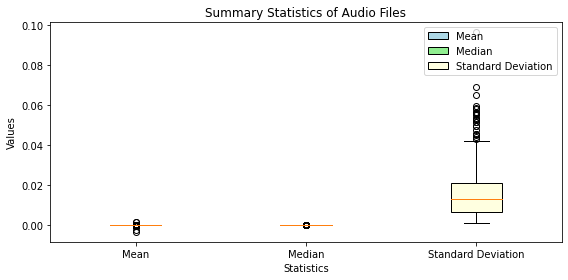

<ipython-input-6-e9e5ec888d8b>:49: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max), y_axis='log', x_axis='time', sr=sr)


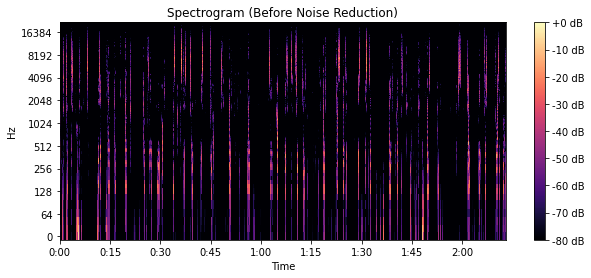

<ipython-input-6-e9e5ec888d8b>:57: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y_reduced), ref=np.max), y_axis='log', x_axis='time', sr=sr)


Text(0.5, 1.0, 'Spectrogram (After Noise Reduction)')

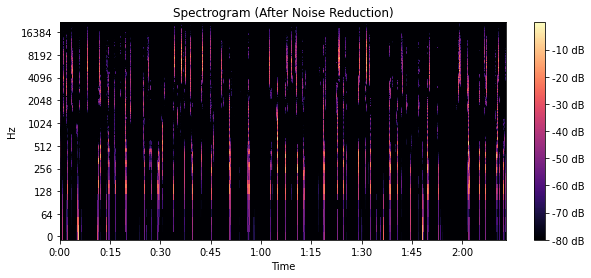

In [6]:
# summerinzing all the audios 
# Function to calculate descriptive statistics for each audio file
def calculate_statistics(audio_files):
    statistics = []
    for audio_file in audio_files:
        try:
            # Load audio data
            y, sr = librosa.load(path+audio_file, sr=None)         
            # Calculate statistics
            mean = np.mean(y)
            median = np.median(y)
            std = np.std(y)         
            # Append statistics to list
            statistics.append({
                'Audio File': audio_file,
                'Mean': mean,
                'Median': median,
                'Standard Deviation': std
            })
        except Exception as e:
            print(f"Error loading {audio_file}: {str(e)}")
    return pd.DataFrame(statistics)
# Calculate descriptive statistics
statistics = calculate_statistics(wav_files)
# Plot boxplot graph
plt.figure(figsize=(8, 4))
plt.title('Summary Statistics of Audio Files')
plt.xlabel('Statistics')
plt.ylabel('Values')
# Create boxplot
boxplot = plt.boxplot(statistics[['Mean', 'Median', 'Standard Deviation']].values, patch_artist=True)
# Add x-axis labels
plt.xticks([1, 2, 3], ['Mean', 'Median', 'Standard Deviation'])
# Fill boxplot with colors
colors = ['lightblue', 'lightgreen', 'lightyellow']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
# Add legend
plt.legend(boxplot['boxes'], ['Mean', 'Median', 'Standard Deviation'], loc='upper right')
# Show plot
plt.tight_layout()
plt.show()

# Load the audio file
audio_path = path+"M_0104_13y3m_1.wav"
y, sr = librosa.load(audio_path, sr=None)  # Load with the original sampling rate
# Plot the spectrogram to visualize the audio
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Before Noise Reduction)')
plt.show()
# Perform noise reduction
y_reduced = reduce_noise(y, sr)
# Plot the spectrogram after noise reduction
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y_reduced), ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (After Noise Reduction)')

In [7]:
def clean_audio(audio_filename):
    # Load the audio file
    y, sr = librosa.load(path+audio_filename, sr=None)  # Load with the original sampling rate
    # Perform noise reduction
    y_reduced = reduce_noise(y, sr)
    # Save the cleaned audio with the same filename as the original
    wavfile.write(new_path+audio_filename, sr, y_reduced)
audio_files = [file for file in os.listdir(path) if file.endswith(".wav")]
# Process each audio file
for audio_filename in audio_files:
    clean_audio(audio_filename)

1

In [8]:
extracted_files=os.listdir(new_path)
wav_files = [file for file in extracted_files if file.endswith('.wav')]
print(len(wav_files))

303


In [43]:
# Function to assess severity of stuttering based on extracted features
def assess_stuttering_severity(pitch, intensity, disfluency_duration, spectral_feature_scalar):
    # Define weights for each feature (you can adjust these based on your analysis)
    pitch_weight = 0.25
    intensity_weight = 0.25
    disfluency_duration_weight = 0.25
    spectral_feature_weight = 0.25
    
    # Combine features using weighted sum
    combined_score = (pitch * pitch_weight +
                      intensity * intensity_weight +
                      disfluency_duration * disfluency_duration_weight +
                      spectral_feature_scalar * spectral_feature_weight)
    
    # Normalize the combined score (optional)
    min_score = min(pitch, intensity, disfluency_duration, spectral_feature_scalar)
    max_score = max(pitch, intensity, disfluency_duration, spectral_feature_scalar)
    normalized_score = (combined_score - min_score) / (max_score - min_score)
    
    return normalized_score

# Function to calculate pitch using Praat
def calculate_pitch(segment, sampling_rate):
    sound = parselmouth.Sound(segment, sampling_frequency=sampling_rate)
    pitch = sound.to_pitch()
    mean_pitch = pitch.selected_array['frequency'].mean()
    return mean_pitch

# Function to calculate intensity
def calculate_intensity(segment):
    energy = np.square(segment)
    rms_amplitude = np.sqrt(np.mean(energy))
    std_deviation = np.std(segment)
    return rms_amplitude

# Function to calculate disfluency duration
def calculate_disfluency_duration(segment, sampling_rate, pause_threshold=0.05):
    energy_env = np.abs(librosa.core.stft(segment))
    energy_per_frame = np.mean(energy_env, axis=0)
    pauses = np.where(energy_per_frame < pause_threshold)[0]
    pause_times = librosa.frames_to_time(pauses, sr=sampling_rate)
    disfluency_duration = np.sum(np.diff(pause_times))
    return disfluency_duration

def calculate_spectral_feature_scalar(segment, sampling_rate):
    # Compute short-time Fourier transform (STFT)
    stft = librosa.stft(segment)

    # Compute power spectrogram
    power_spectrogram = np.abs(stft)**2

    # Compute Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(power_spectrogram),
                                  sr=sampling_rate,
                                  n_mfcc=13)

    # Calculate the mean of MFCCs across all coefficients
    mfccs_mean = np.mean(mfccs)

    return mfccs_mean

# Function to extract features from an audio file
def extract_features(audio_file, max_segment_duration=5):
    try:
        y, sr = librosa.load(new_path+audio_file, sr=None)
        total_duration = librosa.get_duration(y=y, sr=sr)
        num_segments = int(np.ceil(total_duration / max_segment_duration))

        pitch_values = []
        intensity_values = []
        disfluency_durations = []
        spectral_feature_scalars = []
        
        segment_scores = []

        for i in range(num_segments):
            segment_start = i * max_segment_duration
            segment_end = min((i + 1) * max_segment_duration, total_duration)
            segment = y[int(segment_start * sr):int(segment_end * sr)]

            pitch_values.append(calculate_pitch(segment, sr))
            intensity_values.append(calculate_intensity(segment))
            disfluency_durations.append(calculate_disfluency_duration(segment, sr))
            spectral_feature_scalars.append(calculate_spectral_feature_scalar(segment, sr))
            normalized_segment_score = assess_stuttering_severity(pitch_values[i],
                                                             intensity_values[i], 
                                                             disfluency_durations[i], 
                                                             spectral_feature_scalars[i])
            segment_scores.append(normalized_segment_score)
        pitch_values=np.mean(pitch_values)
        intensity_values=np.mean(intensity_values)
        disfluency_durations=np.mean(disfluency_durations)
        spectral_feature_scalars=np.mean(spectral_feature_scalars)
        overall_score = np.mean(segment_scores)
        return [pitch_values,
                intensity_values,
                disfluency_durations,
                spectral_feature_scalars,
                overall_score]

    except Exception as e:
        
        return None
def calculate_mean(audio_files, max_segment_duration=5):
    mean_pitches = []
    mean_intensities = []
    mean_disfluency_durations = []
    mean_spectral_feature_scalars = []
    overall_score = []
    for audio_file in audio_files:
        try:
            features = extract_features(audio_file, max_segment_duration)
            if features:
                mean_pitches.append(features[0])
                mean_intensities.append(features[1])
                mean_disfluency_durations.append(features[2])
                mean_spectral_feature_scalars.append(features[3])
                overall_score.append(features[4])
            else:
                mean_pitches.append(None)  # Append None if features is None
                mean_intensities.append(None)  # Append None if an exception occurs
                mean_disfluency_durations.append(None)  # Append None if features is None                
                mean_spectral_feature_scalars.append(None)  # Append None if features is None
                overall_score.append(None)
        except Exception as e:
            # Do nothing here if an exception occurs
            mean_pitches.append(None)  # Append None if an exception occurs
            mean_intensities.append(None)  # Append None if an exception occurs
            mean_disfluency_durations.append(None)  # Append None if an exception occurs
            mean_spectral_feature_scalars.append(None)  # Append None if an exception occurs
            overall_score.append(None)
    return [mean_pitches,
            mean_intensities,
            mean_disfluency_durations,
            mean_spectral_feature_scalars,
            overall_score]

In [44]:
mean_pitches,mean_intensities,mean_disfluency_durations,mean_spectral_feature_scalars,audio_scores=calculate_mean(wav_files)

setting='replication1/'
np.save('data/'+setting+'mean_pitches.npy',mean_pitches)
np.save('data/'+setting+'mean_intensities.npy',mean_intensities)
np.save('data/'+setting+'mean_disfluency_durations.npy',mean_disfluency_durations)
np.save('data/'+setting+'mean_spectral_feature_scalars.npy',mean_spectral_feature_scalars)
np.save('data/'+setting+'audio_scores.npy',audio_scores)

C:\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1415
  warnings.warn(


In [10]:
setting='replication1/'

mean_pitches=np.load('data/'+setting+'mean_pitches.npy',allow_pickle=True)
mean_intensities=np.load('data/'+setting+'mean_intensities.npy',allow_pickle=True)
mean_disfluency_durations=np.load('data/'+setting+'mean_disfluency_durations.npy',allow_pickle=True)
mean_spectral_feature_scalars=np.load('data/'+setting+'mean_spectral_feature_scalars.npy',allow_pickle=True)
audio_scores=np.load('data/'+setting+'audio_scores.npy',allow_pickle=True)

In [12]:
col1_R1_mon=  R1_mon.iloc[:,0]
col1_R2_mon= R2_mon.iloc[:,0]
col1_R2_con= R2_con.iloc[:,0]
col1_R2_red= R2_Read.iloc[:,0] 

scores_R2_mon = []
scores_R2_con = []
scores_R2_red = []
scores_R1_mon = []
for audio_file in col1_R1_mon: 
    try:
        index = wav_files.index(audio_file + ".wav")
        scores_R1_mon.append(audio_scores[index])
    except:
        scores_R1_mon.append(None)
for audio_file in col1_R2_con: 
    try:
        index = wav_files.index(audio_file + ".wav")
        scores_R2_con.append(audio_scores[index])
    except:
        scores_R2_con.append(None)
for audio_file in col1_R2_mon: 
    try:
        index = wav_files.index(audio_file + ".wav")
        scores_R2_mon.append(audio_scores[index])
    except:
        scores_R2_mon.append(None)
for audio_file in col1_R2_red: 
    try:
        index = wav_files.index(audio_file + ".wav")
        scores_R2_red.append(audio_scores[index])
    except:
        scores_R2_red.append(None)
# Filter out None values from each group 
scores_R1_mon_filtered = [score for score in scores_R1_mon if score is not None]
scores_R2_mon_filtered = [score for score in scores_R2_mon if score is not None]
scores_R2_con_filtered = [score for score in scores_R2_con if score is not None]
scores_R2_red_filtered = [score for score in scores_R2_red if score is not None]

In [13]:
combined_scores_mon = scores_R1_mon_filtered + scores_R2_mon_filtered
# Perform ANOVA
f_statistic, p_value = f_oneway(combined_scores_mon, scores_R2_con_filtered, scores_R2_red_filtered)

# Print results
print("ANOVA Results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There are significant differences in stuttering severity scores between groups.")
else:
    print("Fail to reject the null hypothesis. There are no significant differences in stuttering severity scores between groups.")
    
# Perform Tukey's HSD post hoc test 
if p_value < alpha:
    data = np.concatenate([scores_R2_mon_filtered, scores_R2_con_filtered, scores_R2_red_filtered])
    # Remove the 'R2_' prefix from the labels
    labels = ['mon'] * len(scores_R2_mon_filtered) + ['con'] * len(scores_R2_con_filtered) + ['red'] * len(scores_R2_red_filtered)
    tukey_results = pairwise_tukeyhsd(data, labels, alpha=0.05)

    # Print Tukey's HSD results
    print("\nTukey's HSD Results:")
    print(tukey_results)

ANOVA Results:
F-statistic: 9.194008252503806
p-value: 0.0001228992137686721
Reject the null hypothesis. There are significant differences in stuttering severity scores between groups.

Tukey's HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   con    mon  -0.0036 0.8384 -0.0195  0.0123  False
   con    red  -0.0153 0.0372   -0.03 -0.0007   True
   mon    red  -0.0117 0.2193 -0.0283  0.0048  False
----------------------------------------------------


In [14]:
#Orginizing the data 

# Add the name of situation to each DataFrame
R1_mon['situation'] = 'monologue'
R2_mon['situation'] = 'monologue'
R2_con['situation'] = 'conversation'
R2_Read['situation'] = 'reading'

# Create a dictionary to map filenames (without .wav) to their scores
file_scores = {filename[:-4]: score for filename, score in zip(wav_files, audio_scores)}

# Function to get the score for a filename (without .wav), returns None if filename not found
def get_score(filename):
    return file_scores.get(filename)

# Adding the audio scores that are relevant to each file
R1_mon["audio_score"] = [get_score(x) for x in col1_R1_mon]
R2_mon["audio_score"] = [get_score(x) for x in col1_R2_mon]
R2_con["audio_score"] = [get_score(x) for x in col1_R2_con]
R2_Read["audio_score"] = [get_score(x) for x in col1_R2_red]  

# Create dictionaries for each feature
pitch_scores_dict = {}
intensity_scores_dict = {}
disfluency_duration_dict = {}
spectral_feature_scalar_dict = {}

# Populate dictionaries with scores for each observation
for filename, score in zip(wav_files, mean_pitches):
    filename_key = filename[:-4]  # Removing the .wav extension
    pitch_scores_dict[filename_key] = score

for filename, score in zip(wav_files, mean_intensities):
    filename_key = filename[:-4]  # Removing the .wav extension
    intensity_scores_dict[filename_key] = score

for filename, score in zip(wav_files, mean_disfluency_durations):
    filename_key = filename[:-4]  # Removing the .wav extension
    disfluency_duration_dict[filename_key] = score

for filename, score in zip(wav_files, mean_spectral_feature_scalars):
    filename_key = filename[:-4]  # Removing the .wav extension
    spectral_feature_scalar_dict[filename_key] = score
# Define functions to get scores for each feature
def get_pitch_score(filename):
    return pitch_scores_dict.get(filename)

def get_intensity_score(filename):
    return intensity_scores_dict.get(filename)

def get_disfluency_duration(filename):
    return disfluency_duration_dict.get(filename)

def get_spectral_feature_scalar(filename):
    return spectral_feature_scalar_dict.get(filename)

# Add scores for each feature to DataFrames
R1_mon["pitch_score"] = [get_pitch_score(x) for x in col1_R1_mon]
R1_mon["intensity_score"] = [get_intensity_score(x) for x in col1_R1_mon]
R1_mon["disfluency_duration"] = [get_disfluency_duration(x) for x in col1_R1_mon]
R1_mon["spectral_feature_scalar"] = [get_spectral_feature_scalar(x) for x in col1_R1_mon]

R2_mon["pitch_score"] = [get_pitch_score(x) for x in col1_R2_mon]
R2_mon["intensity_score"] = [get_intensity_score(x) for x in col1_R2_mon]
R2_mon["disfluency_duration"] = [get_disfluency_duration(x) for x in col1_R2_mon]
R2_mon["spectral_feature_scalar"] = [get_spectral_feature_scalar(x) for x in col1_R2_mon]

R2_con["pitch_score"] = [get_pitch_score(x) for x in col1_R2_con]
R2_con["intensity_score"] = [get_intensity_score(x) for x in col1_R2_con]
R2_con["disfluency_duration"] = [get_disfluency_duration(x) for x in col1_R2_con]
R2_con["spectral_feature_scalar"] = [get_spectral_feature_scalar(x) for x in col1_R2_con]

R2_Read["pitch_score"] = [get_pitch_score(x) for x in col1_R2_red]
R2_Read["intensity_score"] = [get_intensity_score(x) for x in col1_R2_red]
R2_Read["disfluency_duration"] = [get_disfluency_duration(x) for x in col1_R2_red]
R2_Read["spectral_feature_scalar"] = [get_spectral_feature_scalar(x) for x in col1_R2_red]


def format_words(words):
    formatted_words = []
    for word in words:
        # Convert to lowercase, remove leading and trailing spaces, and replace inner spaces with underscores
        formatted_word = word.strip().lower().replace(" ", "_")
        formatted_words.append(formatted_word)
    return formatted_words

col_new_R1_mon = format_words(R1_mon) 
col_new_R1_mon = ["age_at_onset" if x == "age_of_onset" else x for x in col_new_R1_mon]  #chaning age_of_onset to age_at_onset (: 

col_new_R2_mon = format_words(R2_mon)
col_new_R2_con = format_words(R2_con)
col_new_R2_Read = format_words(R2_Read)

R1_mon.columns= col_new_R1_mon
R2_mon.columns= col_new_R2_mon
R2_con.columns= col_new_R2_con
R2_Read.columns= col_new_R2_Read

final_data = pd.concat([R1_mon, R2_mon, R2_con, R2_Read], ignore_index=True)
final_data_reset= final_data # we use it to reset (instead of running the first code again)

all_var= final_data.columns.tolist()

# Ensure no leading/trailing spaces
final_data['gender'] = final_data['gender'].str.strip()
# Ensure consistent data types
final_data['gender'] = final_data['gender'].astype(str)
# Replace 'F' with 'Female' and 'M' with 'Male'
final_data['gender'] = final_data['gender'].replace({'F': 'Female', 'M': 'Male'})
# Ensure no leading/trailing spaces
final_data['type_of_therapy'] = final_data['type_of_therapy'].str.strip()
# Ensure consistent data types
final_data['type_of_therapy'] = final_data['type_of_therapy'].astype(str)
# Replace values in the 'type_of_therapy' column
final_data['type_of_therapy'] = final_data['type_of_therapy'].replace({'F': 'Family', 'H': 'Holistic'})

#number of all the observations 
num_observations = len(final_data)
print("Number of all observations:", num_observations)
# Counting NA in each variable
na_counts = final_data.isna().sum()
print("\nNA counts in each variable:")
print(na_counts) #missing values in each variable
# Fill NaN values with 'unknown' in the 'handedness' column
final_data['handedness'] = final_data['handedness'].fillna('not known')
# Fill NaN values with 'unknown' in the 'family_history' column
final_data['family_history'] = final_data['family_history'].fillna('not known')
# Check unique values in the 'family_history' column
print(final_data['family_history'].unique())

#######


###Imputation for 'age_at_onset ' :  
# Convert 'not known' to NaN in the 'age_at_onset' column
final_data['age_at_onset'] = final_data['age_at_onset'].replace('not known', pd.NA)

# Convert the column to numeric type
final_data['age_at_onset'] = pd.to_numeric(final_data['age_at_onset'])

# Fill NaN values with mean in the 'age_at_onset' column
mean_value = final_data['age_at_onset'].mean()
final_data['age_at_onset'] = final_data['age_at_onset'].fillna(mean_value)

# Check unique values in the 'age_at_onset' column
print(final_data['age_at_onset'].unique())

threshold = 0.4  # Example threshold, adjust as needed
variables_to_keep = na_counts[na_counts / num_observations <= threshold].index
variables_to_delete = na_counts[na_counts / num_observations > threshold].index
final_data_filtered = final_data[variables_to_keep].copy()

final_data_filtered= final_data_filtered.dropna() 

num_rows, num_cols = final_data_filtered.shape

cols_to_factorize = ['gender', 'handedness', 'family_history', 'where_recorded',
                     'recording_conditions', 'type_of_therapy', 'hearing_problems',
                     'language_problems', 'sen', 'orthographic', 'phonetic', 
                     'time_aligned',  
                     'situation' , 'phl']

# Convert selected columns to factors
final_data_filtered[cols_to_factorize] = final_data[cols_to_factorize].apply(lambda x: pd.factorize(x)[0])

# Reset index
final_data_filtered.reset_index(inplace=True)

# Drop 'file_name' and 'index' columns if they exist
if 'file_name' in final_data_filtered.columns:
    final_data_filtered.drop(columns='file_name', inplace=True)
if 'index' in final_data_filtered.columns:
    final_data_filtered.drop(columns='index', inplace=True) 
    # Drop 'level_0' column
if 'level_0' in final_data_filtered.columns:
    final_data_filtered.drop(columns='level_0', inplace=True)

Number of all observations: 455

NA counts in each variable:
file_name                               0
gender                                  0
handedness                              0
family_history                          0
age_at_onset                            0
age_at_recording                        0
where_recorded                          0
recording_conditions                    0
type_of_therapy                         0
time_between_therapy_and_recording      0
hearing_problems                        0
language_problems                       0
sen                                     0
orthographic                            0
phonetic                                0
time_aligned                            0
tape_noise                              0
env_noise                               0
speaker_quality                         0
interruptions                           0
situation                               0
audio_score                            19
pitch_score    

In [16]:
# part 1
#Standardizing the data

final_data_filtered_stan = final_data_filtered.copy()
# Categorical columns as specified
categorical_columns = [
    'gender', 'handedness', 'family_history', 'where_recorded',
    'recording_conditions', 'type_of_therapy', 'hearing_problems',
    'language_problems', 'sen', 'orthographic', 'phonetic', 
    'time_aligned', 'situation', 'phl'
]

# Identify numeric columns by excluding the categorical columns
numeric_columns = final_data_filtered_stan.columns.difference(categorical_columns).tolist()

# Standardize the numeric columns
scaler = StandardScaler()
final_data_filtered_stan[numeric_columns] = scaler.fit_transform(final_data_filtered_stan[numeric_columns])

# Combine the standardized numeric columns with the categorical columns
final_data_filtered_stan = pd.concat([final_data_filtered_stan[categorical_columns], final_data_filtered_stan[numeric_columns]], axis=1)

print(final_data_filtered_stan)

     gender  handedness  family_history  where_recorded  recording_conditions  \
0         0           0               0               0                     0   
1         0           0               0               0                     0   
2         0           0               0               0                     0   
3         0           0               0               0                     0   
4         0           0               0               1                     0   
..      ...         ...             ...             ...                   ...   
300       1           0               2               0                     0   
301       1           0               1               0                     0   
302       1           0               2               0                     0   
303       1           0               1               0                     0   
304       1           0               2               0                     0   

     type_of_therapy  heari

Accuracy: 0.5434782608695652
Mean Squared Error (MSE): 1.0108695652173914


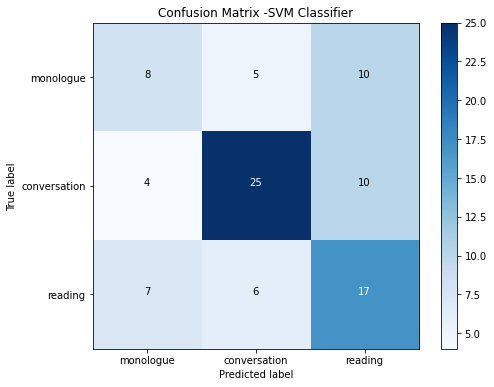

Cross-Validation Scores: [0.62295082 0.44262295 0.52459016 0.55737705 0.52459016]
Mean Cross-Validation Score: 0.5344262295081967
Standard Deviation of Cross-Validation Scores: 0.05828324208075796


In [17]:
#Dividing the data into train and test

from sklearn.model_selection import train_test_split

# Extract features and labels
X = final_data_filtered_stan.drop(columns=['situation'])  # Features
y = final_data_filtered_stan['situation']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
## SVM without cross validation and Confusion matrix

# Train SVM classifier
svm_classifier = SVC(kernel='linear') 
svm_classifier.fit(X_train, y_train)

# Predictions
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy_SVM_way1 = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_SVM_way1)

# Calculate mean squared error (MSE)
mse_SVM_way1 = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_SVM_way1)

#general function that We will use to the other methods
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Add text annotations for each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.colorbar()
    plt.show()
    
custom_classes = ['monologue', 'conversation', 'reading']
plot_confusion_matrix(y_test, y_pred, custom_classes, 'Confusion Matrix -SVM Classifier')

## SVM with cross validation
svm_classifier = SVC(kernel='linear')

# 5 folds
cv_scores = cross_val_score(svm_classifier, X, y, cv=5)

# the scores of cross-validation: 
print("Cross-Validation Scores:", cv_scores)

#  mean and standard deviation of cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)


Random Forest Accuracy: 0.41304347826086957
Random Forest Mean Squared Error (MSE): 1.2065217391304348


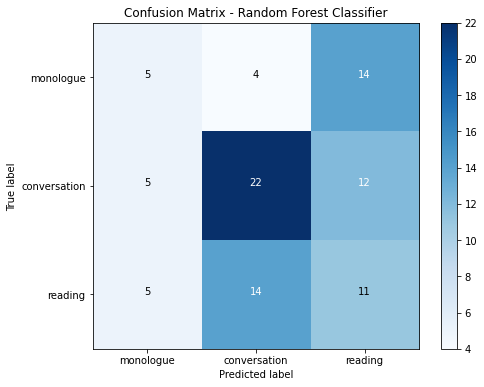

In [18]:
## Random forest classifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_classifier.predict(X_test)

# check  accuracy
accuracy_rf_way1 = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf_way1)

# Check MSE 
mse_rf_way1 = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Mean Squared Error (MSE):", mse_rf_way1)

# Plot confusion matrix for Random Forest Classifier
plot_confusion_matrix(y_test, y_pred_rf, custom_classes, 'Confusion Matrix - Random Forest Classifier')


C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k-NN Classifier Accuracy: 0.43478260869565216
k-NN Classifier Mean Squared Error (MSE): 1.184782608695652


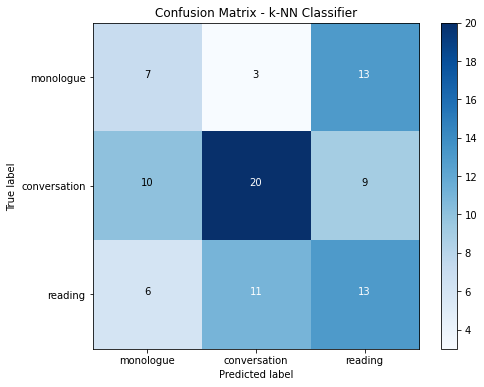

In [19]:
## k-Nearest Neighbors Classifier 
# Train k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_classifier.predict(X_test)

# Calculate accuracy
accuracy_knn_way1 = accuracy_score(y_test, y_pred_knn)
print("k-NN Classifier Accuracy:", accuracy_knn_way1)

# Calculate mean squared error (MSE)
mse_knn_way1 = mean_squared_error(y_test, y_pred_knn)
print("k-NN Classifier Mean Squared Error (MSE):", mse_knn_way1)

plot_confusion_matrix(y_test, y_pred_knn, custom_classes, 'Confusion Matrix - k-NN Classifier')

Logistic Regression Classifier Accuracy: 0.5652173913043478
Logistic Regression Classifier Mean Squared Error (MSE): 0.9891304347826086


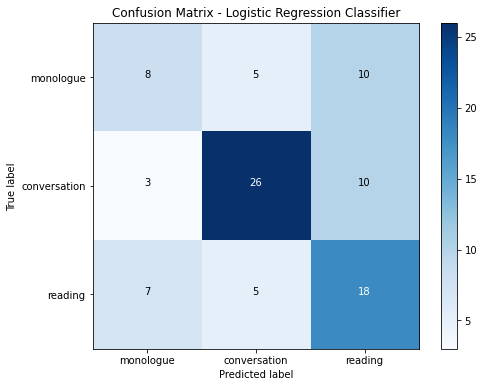

In [20]:
## Logistic Regression Classifier
# Train logistic regression classifier with adjusted solver and increased max_iter
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=2000)
logistic_classifier.fit(X_train, y_train)

# Predictions
y_pred_logistic = logistic_classifier.predict(X_test)

# Calculate accuracy
accuracy_logistic_way1 = accuracy_score(y_test, y_pred_logistic)
print("Logistic Regression Classifier Accuracy:", accuracy_logistic_way1)

# Calculate mean squared error (MSE)
mse_logistic_way1 = mean_squared_error(y_test, y_pred_logistic)
print("Logistic Regression Classifier Mean Squared Error (MSE):", mse_logistic_way1)

plot_confusion_matrix(y_test, y_pred_logistic, custom_classes, 'Confusion Matrix - Logistic Regression Classifier')

In [21]:
# part 2
# Changing the situation variable to have 2 categories
# Combining "Reading, Monologue" in the same category and conversation in the other
final_data_filtered_way2 = final_data_filtered.copy()

# Map 'monologue' and 'reading' to 0, and 'conversation' to 1
final_data_filtered_way2['situation'] = final_data_filtered_way2['situation'].replace({0: 0, 1: 1, 2: 0})

# Confirm the changes
print(final_data_filtered_way2['situation'].unique())

# To check that final_data_filtered is unchanged
print(final_data_filtered['situation'].unique())

#Work on the standarized data
final_data_filtered_way2_stan = final_data_filtered_stan.copy()

# Map 'monologue' and 'reading' to 0, and 'conversation' to 1
final_data_filtered_way2_stan['situation'] = final_data_filtered_way2_stan['situation'].replace({0: 0, 1: 1, 2: 0})

# Confirm the changes
print(final_data_filtered_way2_stan['situation'].unique())

# To check that final_data_filtered is unchanged
print(final_data_filtered_stan['situation'].unique())

# Extract features and labels
X = final_data_filtered_way2_stan.drop(columns=['situation'])  # Features
y = final_data_filtered_way2_stan['situation']  # Labels

X_train_way2, X_test_way2, y_train_way2, y_test_way2 = train_test_split(X, y, test_size=0.3, random_state=42)


[0 1]
[0 1 2]
[0 1]
[0 1 2]


Accuracy: 0.717391304347826
Mean Squared Error (MSE): 0.2826086956521739


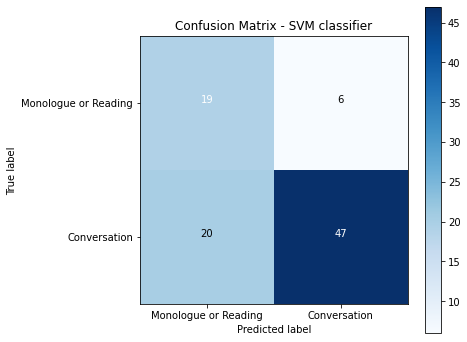

Cross-Validation Scores: [0.63934426 0.60655738 0.70491803 0.7704918  0.6557377 ]


In [22]:
## SVM without cross validation

# Train SVM classifier
svm_classifier = SVC(kernel='linear')  # You can try different kernels like 'rbf' or 'poly'
svm_classifier.fit(X_train_way2, y_train_way2)

# Predictions
y_pred_way2 = svm_classifier.predict(X_test_way2)

# Calculate accuracy
accuracy_SVM_way2 = accuracy_score(y_test_way2, y_pred_way2)
print("Accuracy:", accuracy_SVM_way2 )

# Calculate mean squared error (MSE)
mse_SVM_way2 = mean_squared_error(y_test_way2, y_pred_way2)
print("Mean Squared Error (MSE):", mse_SVM_way2 )

# Function to plot simplified confusion matrix for binary classification with custom class labels
def plot_binary_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]  # Extract values from confusion matrix
    
    plt.figure(figsize=(6, 6))  # Adjust the figure size here
    plt.imshow([[tp, fp], [fn, tn]], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Add text annotations for each cell
    plt.text(0, 0, tp, horizontalalignment="center", color="white")
    plt.text(1, 0, fp, horizontalalignment="center", color="black")
    plt.text(0, 1, fn, horizontalalignment="center", color="black")
    plt.text(1, 1, tn, horizontalalignment="center", color="white")

    plt.colorbar()
    plt.show()

custom_classes_combined = ['Monologue or Reading', 'Conversation']

# Replace y_pred_way2 with the predicted labels obtained from the classifier trained on the combined dataset (way2)
# Plot confusion matrix for the combined categories
plot_binary_confusion_matrix(y_test_way2, y_pred_way2, custom_classes_combined, 'Confusion Matrix - SVM classifier')
## SVM with cross validation
svm_classifier = SVC(kernel='linear')

# 5 folds
cv_scores = cross_val_score(svm_classifier, X, y, cv=5)

# the scores of cross-validation: 
print("Cross-Validation Scores:", cv_scores)

#  mean and standard deviation of cross-validation scores
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()


Random Forest Accuracy: 0.6086956521739131
Random Forest Mean Squared Error (MSE): 1.2065217391304348


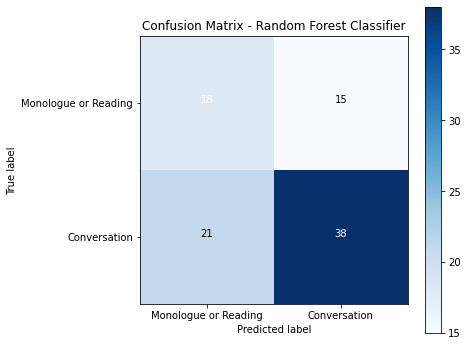

In [23]:
## Random Forest Classifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Train Random Forest Classifier
rf_classifier.fit(X_train_way2, y_train_way2)

# Predictions
y_pred_rf_way2 = rf_classifier.predict(X_test_way2)

# check  accuracy
accuracy_rf_way2 = accuracy_score(y_test_way2, y_pred_rf_way2)
print("Random Forest Accuracy:", accuracy_rf_way2)

# Check MSE 
mse_rf_way2 = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Mean Squared Error (MSE):", mse_rf_way2)

custom_classes_combined = ['Monologue or Reading', 'Conversation']

# Plot confusion matrix for the combined categories - SVM classifier
plot_binary_confusion_matrix(y_test_way2, y_pred_rf_way2, custom_classes_combined, 'Confusion Matrix - Random Forest Classifier')


k-NN Classifier Accuracy: 0.6195652173913043
k-NN Classifier Mean Squared Error (MSE): 0.3804347826086957


C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


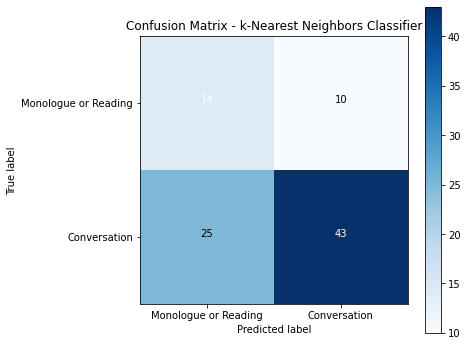

In [24]:
## k-Nearest Neighbors Classifier 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# Train k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_way2, y_train_way2)

# Predictions
y_pred_knn = knn_classifier.predict(X_test_way2)

# Calculate accuracy
accuracy_knn_way2 = accuracy_score(y_test_way2, y_pred_knn)
print("k-NN Classifier Accuracy:", accuracy_knn_way2)

# Calculate mean squared error (MSE)
mse_knn_way2 = mean_squared_error(y_test_way2, y_pred_knn)
print("k-NN Classifier Mean Squared Error (MSE):", mse_knn_way2)

plot_binary_confusion_matrix(y_test_way2, y_pred_knn, custom_classes_combined, 'Confusion Matrix - k-Nearest Neighbors Classifier')

Logistic Regression Classifier Accuracy: 0.7391304347826086
Logistic Regression Classifier Mean Squared Error (MSE): 0.2608695652173913


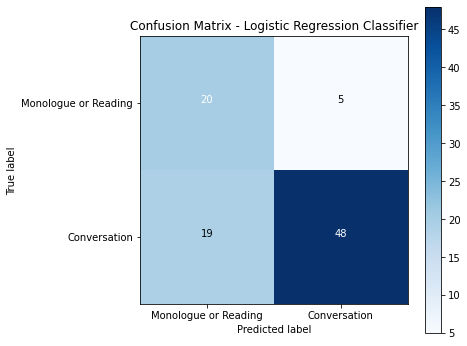

In [25]:
#Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error

# Train logistic regression classifier with adjusted solver
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_classifier.fit(X_train_way2, y_train_way2)

# Predictions
y_pred_logistic = logistic_classifier.predict(X_test_way2)

# Calculate accuracy
accuracy_logistic_way2 = accuracy_score(y_test_way2, y_pred_logistic)
print("Logistic Regression Classifier Accuracy:", accuracy_logistic_way2)

# Calculate mean squared error (MSE)
mse_logistic_way2 = mean_squared_error(y_test_way2, y_pred_logistic)
print("Logistic Regression Classifier Mean Squared Error (MSE):", mse_logistic_way2)

plot_binary_confusion_matrix(y_test_way2, y_pred_logistic, custom_classes_combined, 'Confusion Matrix - Logistic Regression Classifier')

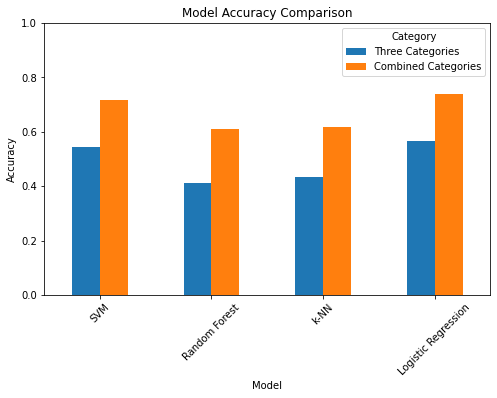

In [26]:
## Accuracy bar plots

# Accuracy scores for each model
accuracies = {
    'Model': ['SVM', 'Random Forest', 'k-NN', 'Logistic Regression'],
    'Three Categories': [accuracy_SVM_way1, accuracy_rf_way1, accuracy_knn_way1,accuracy_logistic_way1],
    'Combined Categories': [accuracy_SVM_way2 ,accuracy_rf_way2,accuracy_knn_way2, accuracy_logistic_way2]
}

# Create DataFrame for plotting
accuracy_df = pd.DataFrame(accuracies)

# Plotting
accuracy_df.plot(x='Model', kind='bar', figsize=(8, 5))
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.show()

In [27]:
# Clustering - On the original data without standardizing

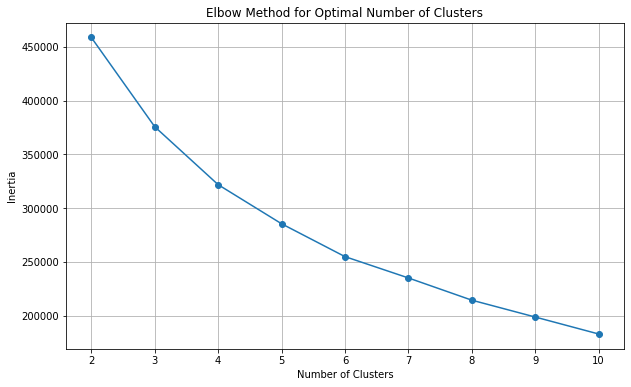

Optimal number of clusters: 2


In [28]:
## K-means
## choosing the optimal k by Elbow method
# Assuming final_data_filtered is a pandas DataFrame
# Extract the values from the DataFrame
data = final_data_filtered.values

# Define the range of potential number of clusters to try
clusters_range = range(2, 11)  # Try cluster numbers from 2 to 10

# Initialize an empty list to store the inertia (within-cluster sum of squared distances) for each cluster number
inertia = []

# Run KMeans for each number of clusters and store the inertia
for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertia, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(clusters_range)
plt.grid(True)
plt.show()

# Find the elbow point programmatically
def find_elbow_point(inertia):
    # Calculate the differences in inertia
    differences = np.diff(inertia)

    # Calculate the second derivative of the inertia
    second_derivative = np.diff(differences)

    # Find the index corresponding to the maximum second derivative
    elbow_index = np.argmax(second_derivative) + 1  # Add 1 to shift index by 1

    return elbow_index

# Find the index of the elbow point
elbow_index = find_elbow_point(inertia)

# Optimal number of clusters
optimal_n_clusters = elbow_index + 1  # Add 1 to shift index by 1

print("Optimal number of clusters:", optimal_n_clusters)

0    Cluster A
1    Cluster A
2    Cluster A
3    Cluster A
4    Cluster B
dtype: object
Principal Component 1 explains 13.56% of the variance.
Principal Component 2 explains 10.67% of the variance.


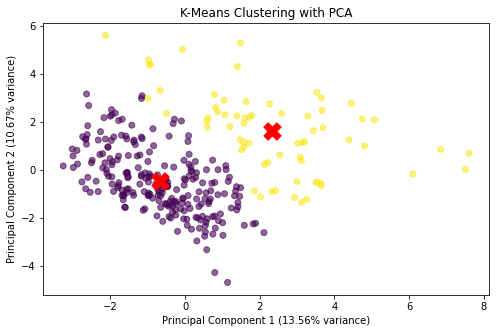

In [32]:
### plot k=2 clusters

# Assuming final_data_filtered is your DataFrame
# Identify numerical and categorical columns
numerical_features = final_data_filtered.select_dtypes(include=['int64', 'float64']).columns
categorical_features = final_data_filtered.select_dtypes(include=['object', 'category']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# K-Means Clustering pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

# Fit and predict clusters
clusters = pipeline.fit_predict(final_data_filtered)

# Mapping cluster numbers to meaningful names
cluster_names = {0: 'Cluster A', 1: 'Cluster B'}
cluster_name_variable_k2 = pd.Series(clusters).map(cluster_names)

# Print the first few entries of the cluster name variable
print(cluster_name_variable_k2.head())

# Adding the cluster labels to the DataFrame
final_data_filtered['Cluster'] = clusters 

final_data_filtered_way2_clusters = final_data_filtered_way2.copy()

final_data_filtered_way2_clusters["cluster"]=clusters 


#For stan

final_data_filtered_way2_clusters_stan = final_data_filtered_way2_stan.copy()

final_data_filtered_way2_clusters_stan["cluster"]=clusters 


# Applying PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pipeline.named_steps['preprocessor'].transform(final_data_filtered.drop('Cluster', axis=1)))

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance for each principal component
print(f"Principal Component 1 explains {explained_variance_ratio[0] * 100:.2f}% of the variance.")
print(f"Principal Component 2 explains {explained_variance_ratio[1] * 100:.2f}% of the variance.")

# Plotting the clusters in 2D
plt.figure(figsize=(8, 5))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(pca.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 0], pca.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 1], s=300, c='red', marker='X')
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0] * 100:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1] * 100:.2f}% variance)')
plt.title('K-Means Clustering with PCA')
plt.show()

In [34]:
final_data_filtered_way2_clusters_stan = final_data_filtered_way2_stan.copy()

final_data_filtered_way2_clusters_stan["cluster"]=clusters 
final_data_filtered_way2_clusters_stan["cluster"]=final_data_filtered_way2_clusters_stan["cluster"].replace({1:0,2:1}) 

#Dividing the data into train and test
X = final_data_filtered_way2_clusters_stan.drop(columns=['situation'])  # Features
y = final_data_filtered_way2_clusters_stan['situation']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize dictionaries to store accuracy values
accuracy_dict = {}
mean_cv_score_dict = {}
std_cv_score_dict = {}

# SVM 
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_dict['SVM'] = accuracy_score(y_test, y_pred_svm)

# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_classifier, X, y, cv=5)
mean_cv_score_dict['SVM'] = cv_scores_svm.mean()
std_cv_score_dict['SVM'] = cv_scores_svm.std()

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_dict['Random Forest'] = accuracy_score(y_test, y_pred_rf)

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_classifier, X, y, cv=5)
mean_cv_score_dict['Random Forest'] = cv_scores_rf.mean()
std_cv_score_dict['Random Forest'] = cv_scores_rf.std()

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_dict['KNN'] = accuracy_score(y_test, y_pred_knn)

# Cross-validation for KNN
cv_scores_knn = cross_val_score(knn_classifier, X, y, cv=5)
mean_cv_score_dict['KNN'] = cv_scores_knn.mean()
std_cv_score_dict['KNN'] = cv_scores_knn.std()

# Logistic Regression
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_classifier.fit(X_train, y_train)
y_pred_logistic = logistic_classifier.predict(X_test)
accuracy_dict['Logistic Regression'] = accuracy_score(y_test, y_pred_logistic)

# Cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(logistic_classifier, X, y, cv=5)
mean_cv_score_dict['Logistic Regression'] = cv_scores_logistic.mean()
std_cv_score_dict['Logistic Regression'] = cv_scores_logistic.std()

# Create DataFrame from accuracy dictionary
accuracy_df_knn2 = pd.DataFrame(accuracy_dict.items(), columns=['Model', 'Accuracy (Train/Test)'])
accuracy_df_knn2['Mean CV Score'] = mean_cv_score_dict.values()
accuracy_df_knn2['Std CV Score'] = std_cv_score_dict.values()
print(accuracy_df_knn2)

                 Model  Accuracy (Train/Test)  Mean CV Score  Std CV Score
0                  SVM               0.717391       0.675410      0.057166
1        Random Forest               0.619565       0.616393      0.051424
2                  KNN               0.619565       0.636066      0.049071
3  Logistic Regression               0.739130       0.662295      0.062725


C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

Principal Component 1 explains 13.56% of the variance.
Principal Component 2 explains 10.67% of the variance.
Principal Component 3 explains 8.35% of the variance.


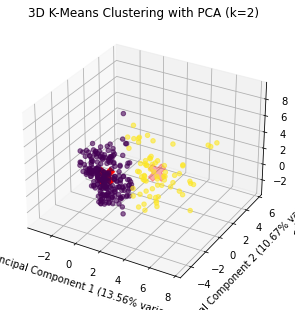

In [35]:
## 3D k=2
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(pipeline.named_steps['preprocessor'].transform(final_data_filtered.drop('Cluster', axis=1)))

# Get the explained variance ratio for 3 components
explained_variance_ratio_3d = pca_3d.explained_variance_ratio_

# Print the explained variance for each principal component
print(f"Principal Component 1 explains {explained_variance_ratio_3d[0] * 100:.2f}% of the variance.")
print(f"Principal Component 2 explains {explained_variance_ratio_3d[1] * 100:.2f}% of the variance.")
print(f"Principal Component 3 explains {explained_variance_ratio_3d[2] * 100:.2f}% of the variance.")

# Plotting the clusters in 3D
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(principal_components_3d[:, 0], principal_components_3d[:, 1], principal_components_3d[:, 2], c=clusters, cmap='viridis', alpha=0.6)
ax.scatter(pca_3d.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 0], 
           pca_3d.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 1], 
           pca_3d.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 2], 
           s=300, c='red', marker='X')
ax.set_xlabel(f'Principal Component 1 ({explained_variance_ratio_3d[0] * 100:.2f}% variance)')
ax.set_ylabel(f'Principal Component 2 ({explained_variance_ratio_3d[1] * 100:.2f}% variance)')
ax.set_zlabel(f'Principal Component 3 ({explained_variance_ratio_3d[2] * 100:.2f}% variance)')
ax.set_title('3D K-Means Clustering with PCA (k=2)')
plt.show()

0    Cluster A
1    Cluster A
2    Cluster A
3    Cluster A
4    Cluster C
dtype: object
Principal Component 1 explains 13.56% of the variance.
Principal Component 2 explains 10.67% of the variance.


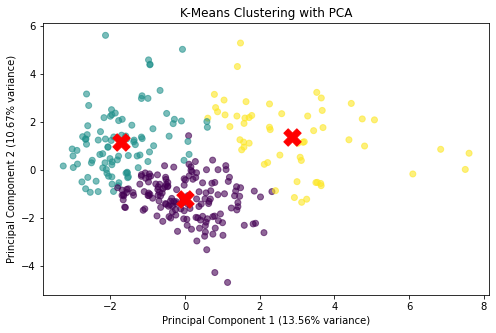

In [36]:
## 2D k=3
# Assuming final_data_filtered is your DataFrame
# Identify numerical and categorical columns
numerical_features = final_data_filtered.select_dtypes(include=['int64', 'float64']).columns
categorical_features = final_data_filtered.select_dtypes(include=['object', 'category']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# K-Means Clustering pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=42))
])

# Fit and predict clusters
clusters = pipeline.fit_predict(final_data_filtered)

# Mapping cluster numbers to meaningful names
cluster_names = {0: 'Cluster A', 1: 'Cluster B', 2: 'Cluster C'}
cluster_name_variable_k3 = pd.Series(clusters).map(cluster_names)

# Print the first few entries of the cluster name variable
print(cluster_name_variable_k3.head())

# Adding the cluster labels to the DataFrame
final_data_filtered['Cluster'] = clusters

# Applying PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pipeline.named_steps['preprocessor'].transform(final_data_filtered))

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance for each principal component
print(f"Principal Component 1 explains {explained_variance_ratio[0] * 100:.2f}% of the variance.")
print(f"Principal Component 2 explains {explained_variance_ratio[1] * 100:.2f}% of the variance.")

# Plotting the clusters in 2D
plt.figure(figsize=(8, 5))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(pca.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 0], pca.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 1], s=300, c='red', marker='X')
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0] * 100:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1] * 100:.2f}% variance)')
plt.title('K-Means Clustering with PCA')
plt.show()


In [37]:

final_data_filtered_way1 = final_data_filtered_stan.copy()
final_data_filtered_way1['cluster']=clusters
# Extract features and labels
X = final_data_filtered_way1.drop(columns=['situation'])  # Features
y = final_data_filtered_way1['situation']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize dictionaries to store accuracy values
accuracy_dict = {}
mean_cv_score_dict = {}
std_cv_score_dict = {}

# SVM 
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_dict['SVM'] = accuracy_score(y_test, y_pred_svm)

# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_classifier, X, y, cv=5)
mean_cv_score_dict['SVM'] = cv_scores_svm.mean()
std_cv_score_dict['SVM'] = cv_scores_svm.std()

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_dict['Random Forest'] = accuracy_score(y_test, y_pred_rf)
# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_classifier, X, y, cv=5)
mean_cv_score_dict['Random Forest'] = cv_scores_rf.mean()
std_cv_score_dict['Random Forest'] = cv_scores_rf.std()

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_dict['KNN'] = accuracy_score(y_test, y_pred_knn)
# Cross-validation for KNN
cv_scores_knn = cross_val_score(knn_classifier, X, y, cv=5)
mean_cv_score_dict['KNN'] = cv_scores_knn.mean()
std_cv_score_dict['KNN'] = cv_scores_knn.std()

# Logistic Regression
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_classifier.fit(X_train, y_train)
y_pred_logistic = logistic_classifier.predict(X_test)
accuracy_dict['Logistic Regression'] = accuracy_score(y_test, y_pred_logistic)
# Cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(logistic_classifier, X, y, cv=5)
mean_cv_score_dict['Logistic Regression'] = cv_scores_logistic.mean()
std_cv_score_dict['Logistic Regression'] = cv_scores_logistic.std()

# Create DataFrame from accuracy dictionary
accuracy_df_knn3 = pd.DataFrame(accuracy_dict.items(), columns=['Model', 'Accuracy (Train/Test)'])
accuracy_df_knn3['Mean CV Score'] = mean_cv_score_dict.values()
accuracy_df_knn3['Std CV Score'] = std_cv_score_dict.values()
print(accuracy_df_knn3)


                 Model  Accuracy (Train/Test)  Mean CV Score  Std CV Score
0                  SVM               0.532609       0.557377      0.083590
1        Random Forest               0.413043       0.524590      0.067988
2                  KNN               0.413043       0.449180      0.084613
3  Logistic Regression               0.597826       0.554098      0.075053


C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

Principal Component 1 explains 13.56% of the variance.
Principal Component 2 explains 10.67% of the variance.
Principal Component 3 explains 8.35% of the variance.


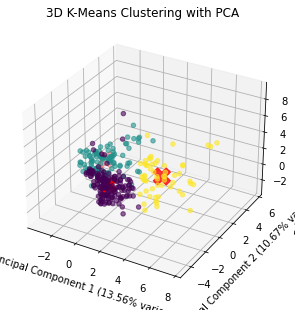

In [38]:
# Applying PCA to reduce dimensionality to 3 components
pca_3d = PCA(n_components=3)
principal_components_3d = pca_3d.fit_transform(pipeline.named_steps['preprocessor'].transform(final_data_filtered))

# Get the explained variance ratio for 3 components
explained_variance_ratio_3d = pca_3d.explained_variance_ratio_

# Print the explained variance for each principal component
print(f"Principal Component 1 explains {explained_variance_ratio_3d[0] * 100:.2f}% of the variance.")
print(f"Principal Component 2 explains {explained_variance_ratio_3d[1] * 100:.2f}% of the variance.")
print(f"Principal Component 3 explains {explained_variance_ratio_3d[2] * 100:.2f}% of the variance.")

# Plotting the clusters in 3D
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(principal_components_3d[:, 0], principal_components_3d[:, 1], principal_components_3d[:, 2], c=clusters, cmap='viridis', alpha=0.6)
ax.scatter(pca_3d.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 0], 
           pca_3d.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 1], 
           pca_3d.transform(pipeline.named_steps['kmeans'].cluster_centers_)[:, 2], 
           s=300, c='red', marker='X')
ax.set_xlabel(f'Principal Component 1 ({explained_variance_ratio_3d[0] * 100:.2f}% variance)')
ax.set_ylabel(f'Principal Component 2 ({explained_variance_ratio_3d[1] * 100:.2f}% variance)')
ax.set_zlabel(f'Principal Component 3 ({explained_variance_ratio_3d[2] * 100:.2f}% variance)')
ax.set_title('3D K-Means Clustering with PCA')
plt.show()

In [39]:
## Adding chi-square test

# Define the mapping dictionary for situations
mapping = {
    0: 'monologue',
    1: 'conversation',
    2: 'reading'
}

# Create a new list with the mapped names for situations
situations_in_dat = [mapping[value] for value in final_data_filtered["situation"]]

# Create a new list with the mapped names for situations in way 2
mapping_way2 = {
    0: 'monologue_reading',
    1: 'conversation',
    2: 'monologue_reading'
}
situations_in_dat_way2 = [mapping_way2[value] for value in final_data_filtered["situation"]]

# Contingency tables
contingency_table_k2 = pd.crosstab(cluster_name_variable_k2, situations_in_dat)
contingency_table_k3 = pd.crosstab(cluster_name_variable_k3, situations_in_dat_way2)

# Chi-square tests
chi2_k2, p_k2, dof_k2, ex_k2 = chi2_contingency(contingency_table_k2)
chi2_k3, p_k3, dof_k3, ex_k3 = chi2_contingency(contingency_table_k3)

# Convert expected frequencies to DataFrame for better visualization
ex_k2_df = pd.DataFrame(ex_k2, index=contingency_table_k2.index, columns=contingency_table_k2.columns)
ex_k3_df = pd.DataFrame(ex_k3, index=contingency_table_k3.index, columns=contingency_table_k3.columns)

# Print the contingency tables
print("Contingency Table for k=2 Clusters:")
print(contingency_table_k2)
print("\nContingency Table for k=3 Clusters:")
print(contingency_table_k3)

# Print the chi-square test results
print("\nChi-Square Test for k=2 Clusters:")
print(f"Chi2 Statistic: {chi2_k2}")
print(f"p-value: {p_k2}")
print(f"Degrees of Freedom: {dof_k2}")
print("\nExpected Frequencies:")
print(ex_k2_df)

print("\nChi-Square Test for k=3 Clusters:")
print(f"Chi2 Statistic: {chi2_k3}")
print(f"p-value: {p_k3}")
print(f"Degrees of Freedom: {dof_k3}")
print("\nExpected Frequencies:")
print(ex_k3_df)



Contingency Table for k=2 Clusters:
col_0      conversation  monologue  reading
row_0                                      
Cluster A           102         65       69
Cluster B            24         12       33

Contingency Table for k=3 Clusters:
col_0      conversation  monologue_reading
row_0                                     
Cluster A            71                 84
Cluster B            35                 59
Cluster C            20                 36

Chi-Square Test for k=2 Clusters:
Chi2 Statistic: 8.61579774604288
p-value: 0.01346180486127256
Degrees of Freedom: 2

Expected Frequencies:
col_0      conversation  monologue   reading
row_0                                       
Cluster A     97.495082  59.580328  78.92459
Cluster B     28.504918  17.419672  23.07541

Chi-Square Test for k=3 Clusters:
Chi2 Statistic: 2.659893287626947
p-value: 0.2644913731743844
Degrees of Freedom: 2

Expected Frequencies:
col_0      conversation  monologue_reading
row_0                        

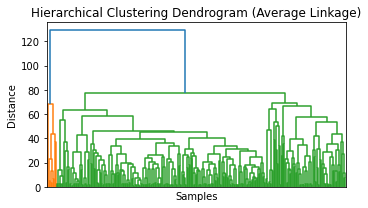

Chi-square statistic: 23.655857272298906
p-value: 9.361649911062522e-05


In [41]:
# Assuming final_data_filtered is your DataFrame with preprocessed data

# Calculate the linkage matrix using average linkage
linkage_matrix_av = linkage(final_data_filtered, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(5, 3))
dendrogram(linkage_matrix_av, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Average Linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(ticks=[], labels=[])
plt.tight_layout()
plt.show()

# Define the mapping dictionary
mapping = {
    0: 'monologue',
    1: 'conversation',
    2: 'reading'
}

# Create a new list with the mapped names
situations_in_dat = [mapping[value] for value in final_data_filtered["situation"]]

# Assuming 'clusters' and 'situations' are the vectors of cluster labels and situation labels
# Create a contingency table
contingency_table = pd.crosstab(clusters, situations_in_dat)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)

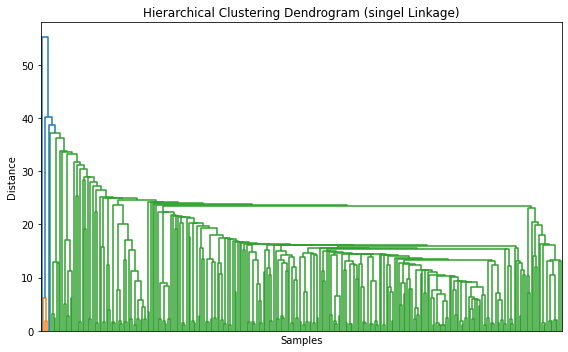

[0 0 0 0 2 1 1 0 0 2 2 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 2
 2 0 1 0 2 2 2 2 1 0 0 0 1 0 0 0 0 0 0 0 1 1 2 0 2 1 0 0 0 0 1 0 0 0 1 0 0
 1 0 1 0 2 1 2 0 0 1 0 0 0 0 1 2 1 0 0 1 1 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0
 0 0 2 2 1 0 0 1 0 0 1 0 1 2 0 0 0 1 2 2 2 0 0 2 1 2 2 0 0 0 1 1 2 0 1 0 0
 0 0 0 2 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 2 0 0 0 0 2 2 2 0 2 0
 0 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 2 2 0 1 1 1 2 2 2 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 2 2 0 0 1 2 2 2 2 1 1 2 1
 2 2 2 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 2 1 1 1 1 2 1 2 2 2 0 0 0 0 0 1 1 0 1
 0 1 1 0 1 1 1 1 1]
Chi-square statistic: 4.762627625633294
p-value: 0.3125316681593818


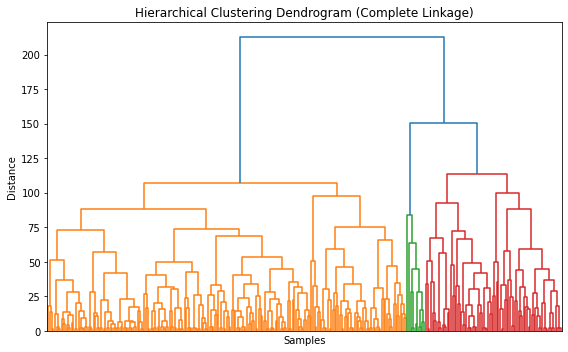

Chi-square statistic: 8.195230260441889
p-value: 0.08468283778701217


In [42]:
### Single method

# Assuming final_data_filtered is your DataFrame with preprocessed data

# Calculate the linkage matrix using average linkage
linkage_matrix_single = linkage(final_data_filtered, method='single', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix_single, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (singel Linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(ticks=[], labels=[])
plt.tight_layout()
plt.show()

# Determine the number of clusters you want
num_clusters = 3

# Cut the dendrogram to obtain clusters
clusters_single = fcluster(linkage_matrix_single, num_clusters, criterion='maxclust')

# Print the cluster assignments
print(clusters)

# Assuming 'clusters' and 'situations' are the vectors of cluster labels and situation labels
# Create a contingency table
contingency_table = pd.crosstab(clusters_single, situations_in_dat)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)


# Assuming final_data_filtered is your DataFrame with preprocessed data

# Calculate the linkage matrix using average linkage
linkage_matrix_comp = linkage(final_data_filtered, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix_comp, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(ticks=[], labels=[])
plt.tight_layout()
plt.show()


# Determine the number of clusters you want
num_clusters = 3

# Cut the dendrogram to obtain clusters
clusters_comp = fcluster(linkage_matrix_comp, num_clusters, criterion='maxclust')

# Assuming 'clusters' and 'situations' are the vectors of cluster labels and situation labels
# Create a contingency table
contingency_table = pd.crosstab(clusters_comp, situations_in_dat)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)

In [43]:
final_data_filtered_way1 = final_data_filtered_stan.copy()
final_data_filtered_way1['cluster']=clusters_single
# Extract features and labels
X = final_data_filtered_way1.drop(columns=['situation'])  # Features
y = final_data_filtered_way1['situation']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize dictionaries to store accuracy values
accuracy_dict = {}
mean_cv_score_dict = {}
std_cv_score_dict = {}

# SVM 
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_dict['SVM'] = accuracy_score(y_test, y_pred_svm)
# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_classifier, X, y, cv=5)
mean_cv_score_dict['SVM'] = cv_scores_svm.mean()
std_cv_score_dict['SVM'] = cv_scores_svm.std()

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_dict['Random Forest'] = accuracy_score(y_test, y_pred_rf)

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_classifier, X, y, cv=5)
mean_cv_score_dict['Random Forest'] = cv_scores_rf.mean()
std_cv_score_dict['Random Forest'] = cv_scores_rf.std()

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_dict['KNN'] = accuracy_score(y_test, y_pred_knn)
# Cross-validation for KNN
cv_scores_knn = cross_val_score(knn_classifier, X, y, cv=5)
mean_cv_score_dict['KNN'] = cv_scores_knn.mean()
std_cv_score_dict['KNN'] = cv_scores_knn.std()

# Logistic Regression
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_classifier.fit(X_train, y_train)
y_pred_logistic = logistic_classifier.predict(X_test)
accuracy_dict['Logistic Regression'] = accuracy_score(y_test, y_pred_logistic)
# Cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(logistic_classifier, X, y, cv=5)
mean_cv_score_dict['Logistic Regression'] = cv_scores_logistic.mean()
std_cv_score_dict['Logistic Regression'] = cv_scores_logistic.std()

# Create DataFrame from accuracy dictionary
accuracy_df_hc3 = pd.DataFrame(accuracy_dict.items(), columns=['Model', 'Accuracy (Train/Test)'])
accuracy_df_hc3['Mean CV Score'] = mean_cv_score_dict.values()
accuracy_df_hc3['Std CV Score'] = std_cv_score_dict.values()
print(accuracy_df_hc3)


                 Model  Accuracy (Train/Test)  Mean CV Score  Std CV Score
0                  SVM               0.554348       0.534426      0.059198
1        Random Forest               0.380435       0.537705      0.091216
2                  KNN               0.434783       0.449180      0.107048
3  Logistic Regression               0.565217       0.557377      0.080978


C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

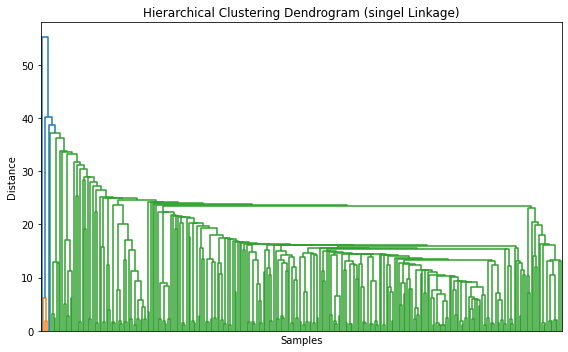

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1]
Chi-square statistic: 2.9707792207792205
p-value: 0.22641411020014138


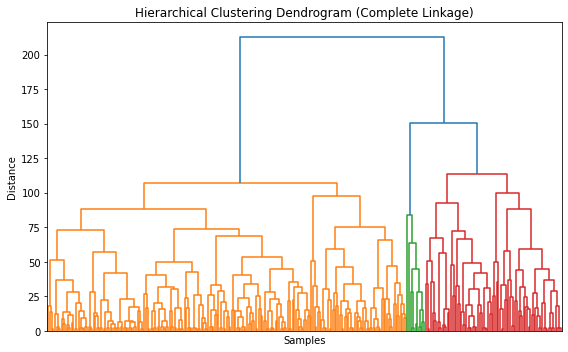

Chi-square statistic: 6.0128427635226736
p-value: 0.04946839086508027


In [44]:
### Single method

# Assuming final_data_filtered is your DataFrame with preprocessed data

# Calculate the linkage matrix using average linkage
linkage_matrix_single = linkage(final_data_filtered, method='single', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix_single, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (singel Linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(ticks=[], labels=[])
plt.tight_layout()
plt.show()

# Determine the number of clusters you want
num_clusters = 2

# Cut the dendrogram to obtain clusters
clusters_single = fcluster(linkage_matrix_single, num_clusters, criterion='maxclust')

# Print the cluster assignments
print(clusters_single)

# Assuming 'clusters' and 'situations' are the vectors of cluster labels and situation labels
# Create a contingency table
contingency_table = pd.crosstab(clusters_single, situations_in_dat)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)


# Assuming final_data_filtered is your DataFrame with preprocessed data

# Calculate the linkage matrix using average linkage
linkage_matrix_comp = linkage(final_data_filtered, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix_comp, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Complete Linkage)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.xticks(ticks=[], labels=[])
plt.tight_layout()
plt.show()


# Determine the number of clusters you want
num_clusters = 2

# Cut the dendrogram to obtain clusters
clusters_comp = fcluster(linkage_matrix_comp, num_clusters, criterion='maxclust')

# Assuming 'clusters' and 'situations' are the vectors of cluster labels and situation labels
# Create a contingency table
contingency_table = pd.crosstab(clusters_comp, situations_in_dat)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("p-value:", p)

In [45]:
final_data_filtered_way2_clusters_stan = final_data_filtered_way2_stan.copy()

final_data_filtered_way2_clusters_stan["cluster"]=clusters_comp 
final_data_filtered_way2_clusters_stan["cluster"]=final_data_filtered_way2_clusters_stan["cluster"].replace({1:0,2:1}) 

# Dividing the data into train and test
X = final_data_filtered_way2_clusters_stan.drop(columns=['situation'])  # Features
y = final_data_filtered_way2_clusters_stan['situation']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize dictionaries to store accuracy values
accuracy_dict = {}
mean_cv_score_dict = {}
std_cv_score_dict = {}

# SVM 
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_dict['SVM'] = accuracy_score(y_test, y_pred_svm)

# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_classifier, X, y, cv=5)
mean_cv_score_dict['SVM'] = cv_scores_svm.mean()
std_cv_score_dict['SVM'] = cv_scores_svm.std()

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_dict['Random Forest'] = accuracy_score(y_test, y_pred_rf)

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_classifier, X, y, cv=5)
mean_cv_score_dict['Random Forest'] = cv_scores_rf.mean()
std_cv_score_dict['Random Forest'] = cv_scores_rf.std()

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_dict['KNN'] = accuracy_score(y_test, y_pred_knn)
# Cross-validation for KNN
cv_scores_knn = cross_val_score(knn_classifier, X, y, cv=5)
mean_cv_score_dict['KNN'] = cv_scores_knn.mean()
std_cv_score_dict['KNN'] = cv_scores_knn.std()

# Logistic Regression
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_classifier.fit(X_train, y_train)
y_pred_logistic = logistic_classifier.predict(X_test)
accuracy_dict['Logistic Regression'] = accuracy_score(y_test, y_pred_logistic)
# Cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(logistic_classifier, X, y, cv=5)
mean_cv_score_dict['Logistic Regression'] = cv_scores_logistic.mean()
std_cv_score_dict['Logistic Regression'] = cv_scores_logistic.std()

# Create DataFrame from accuracy dictionary
accuracy_df_hc2 = pd.DataFrame(accuracy_dict.items(), columns=['Model', 'Accuracy (Train/Test)'])
accuracy_df_hc2['Mean CV Score'] = mean_cv_score_dict.values()
accuracy_df_hc2['Std CV Score'] = std_cv_score_dict.values()
print(accuracy_df_hc2)

                 Model  Accuracy (Train/Test)  Mean CV Score  Std CV Score
0                  SVM               0.717391       0.675410      0.057166
1        Random Forest               0.608696       0.593443      0.058099
2                  KNN               0.619565       0.639344      0.055834
3  Logistic Regression               0.739130       0.662295      0.062725


C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

In [46]:
## NOT IMPORTANT We will see if we determine the number of clusters to 2, whether these significantly dependent with the 2 catigories situations

# Determine the number of clusters you want
num_clusters_2 = 2

# Cut the dendrogram to obtain clusters
clusters_2 = fcluster(linkage_matrix_av, num_clusters_2, criterion='maxclust')

mapping_way2 = {
    0: 'monologue_reading',
    1: 'conversation',
    2: 'monologue_reading'
}

# Create a new list with the mapped names
situations_in_dat_way2 = [mapping_way2[value] for value in final_data_filtered["situation"]]

# Assuming 'clusters' and 'situations' are the vectors of cluster labels and situation labels
# Create a contingency table
contingency_table_2 = pd.crosstab(clusters_2, situations_in_dat_way2)

# Perform Chi-square test
chi2_way2, p_2, dof, expected = chi2_contingency(contingency_table_2)

print("Chi-square statistic:", chi2_way2)
print("p-value:", p_2)

Chi-square statistic: 2.9521901673272284
p-value: 0.08576125968378047


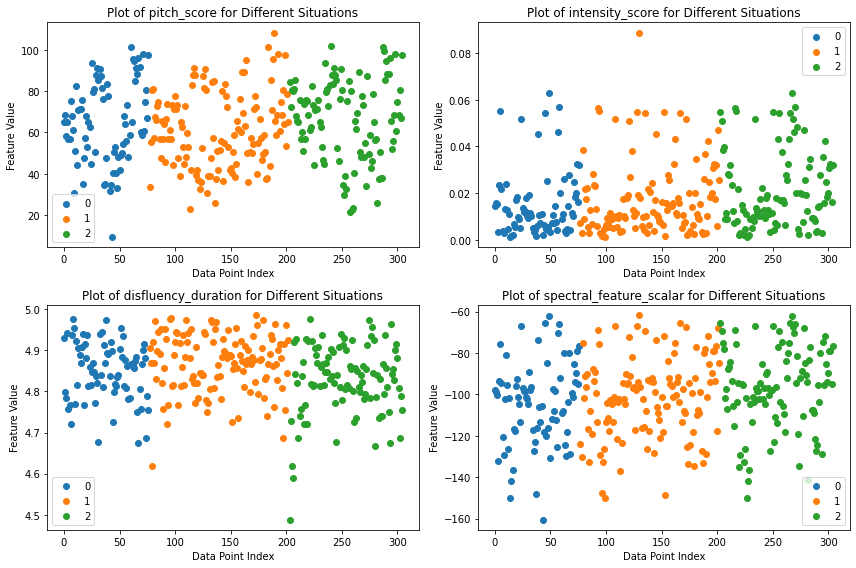

In [47]:
## Discribtive statistic for each feature


# List of features to plot
features = ['pitch_score', 'intensity_score', 'disfluency_duration', 'spectral_feature_scalar']

plt.figure(figsize=(12, 8))

# Plotting for each feature
for i, feature in enumerate(features, start=1):
    plt.subplot(2, 2, i)
    
    # Iterate over each category in the 'situation' variable
    for category in final_data_filtered['situation'].unique():
        # Filter the data for the current category
        data = final_data_filtered[final_data_filtered['situation'] == category]
        # Plot the feature against the index (assuming the index represents data points)
        plt.scatter(data.index, data[feature], label=category)

    # Add labels and legend
    plt.xlabel('Data Point Index')
    plt.ylabel('Feature Value')
    plt.title(f'Plot of {feature} for Different Situations')
    plt.legend()

plt.tight_layout()
plt.show()

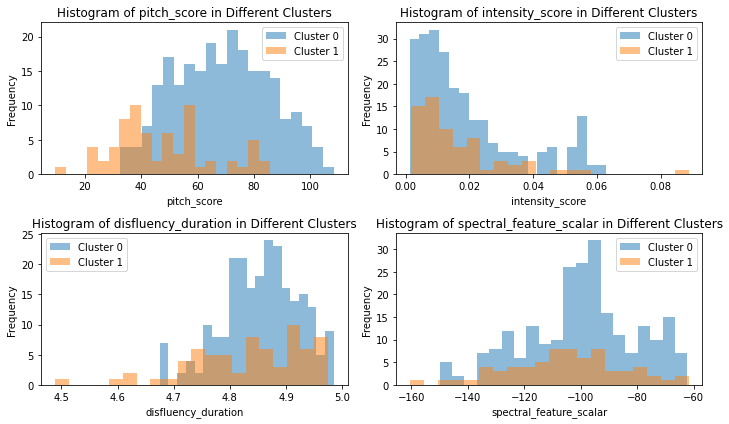

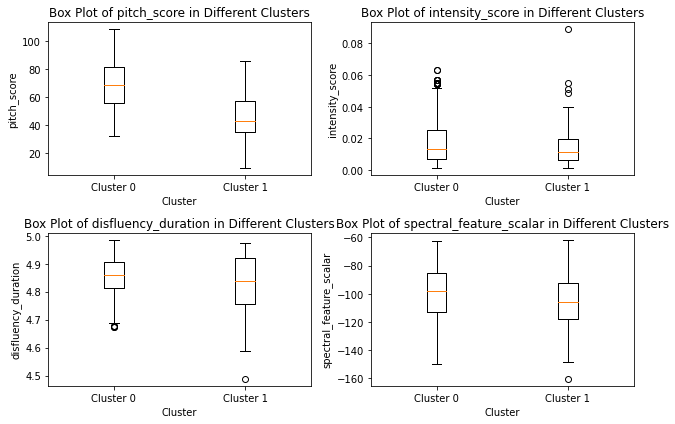

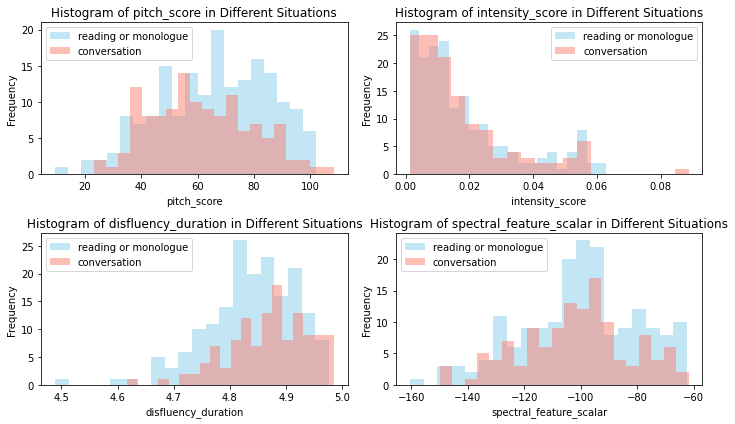

In [48]:
#### 1. Adding the clustering for optimal k=2 2D
#### 2. Adding the histograms
#### 3. Adding a new clusters variables to the data(combined) then applying machine learning methods and compare with machine learning on combined data
## Histograms for features variables, in different clusters

# Define the variables of interest and the clusters
variables_of_interest = ['pitch_score', 'intensity_score', 'disfluency_duration', 'spectral_feature_scalar']
clusters = final_data_filtered_way2_clusters['cluster'].unique()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Loop over each variable and plot in the corresponding subplot
for i, variable in enumerate(variables_of_interest):
    row = i // 2  # Row index for subplot
    col = i % 2   # Column index for subplot
    ax = axes[row, col]  # Get the corresponding axis
    ax.set_title(f'Histogram of {variable} in Different Clusters')
    for cluster in clusters:
        # Filter data for the current cluster
        data_cluster = final_data_filtered_way2_clusters[final_data_filtered_way2_clusters['cluster'] == cluster]
        # Plot histogram for the current variable in the current cluster
        ax.hist(data_cluster[variable], bins=20, alpha=0.5, label=f'Cluster {cluster}')
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Define the variables of interest and the clusters
variables_of_interest = ['pitch_score', 'intensity_score', 'disfluency_duration', 'spectral_feature_scalar']
clusters = final_data_filtered_way2_clusters['cluster'].unique()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6))

# Loop over each variable and plot in the corresponding subplot
for i, variable in enumerate(variables_of_interest):
    row = i // 2  # Row index for subplot
    col = i % 2   # Column index for subplot
    ax = axes[row, col]  # Get the corresponding axis
    ax.set_title(f'Box Plot of {variable} in Different Clusters')
    # Create a list to store boxplot data for each cluster
    boxplot_data = []
    for cluster in clusters:
        # Filter data for the current cluster
        data_cluster = final_data_filtered_way2_clusters[final_data_filtered_way2_clusters['cluster'] == cluster]
        # Add data for the current cluster to the list
        boxplot_data.append(data_cluster[variable])
    # Plot boxplot for the current variable in the current subplot
    ax.boxplot(boxplot_data, labels=[f'Cluster {cluster}' for cluster in clusters])
    ax.set_xlabel('Cluster')
    ax.set_ylabel(variable)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Define the variables of interest and the clusters
variables_of_interest = ['pitch_score', 'intensity_score', 'disfluency_duration', 'spectral_feature_scalar']
situations = final_data_filtered_way2_clusters['situation'].unique()
situation_labels = {0: 'reading or monologue', 1: 'conversation'}  # Define the mapping

# Define custom colors for the histograms
colors = ['skyblue', 'salmon']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Loop over each variable and plot in the corresponding subplot
for i, variable in enumerate(variables_of_interest):
    row = i // 2  # Row index for subplot
    col = i % 2   # Column index for subplot
    ax = axes[row, col]  # Get the corresponding axis
    ax.set_title(f'Histogram of {variable} in Different Situations')
    for situation in situations:
        # Filter data for the current situation
        data_situation = final_data_filtered_way2_clusters[final_data_filtered_way2_clusters['situation'] == situation]
        # Plot histogram for the current variable in the current situation
        ax.hist(data_situation[variable], bins=20, alpha=0.5, label=situation_labels[situation], color=colors[situation])
    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



In [52]:
### without clusters variable

# Dividing the data into train and test
X = final_data_filtered_way2_stan.drop(columns=['situation'])  # Features
y = final_data_filtered_way2_stan['situation']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize dictionaries to store accuracy values
accuracy_dict = {}
mean_cv_score_dict = {}
std_cv_score_dict = {}

# SVM 
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_dict['SVM'] = accuracy_score(y_test, y_pred_svm)

# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_classifier, X, y, cv=5)
mean_cv_score_dict['SVM'] = cv_scores_svm.mean()
std_cv_score_dict['SVM'] = cv_scores_svm.std()

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_dict['Random Forest'] = accuracy_score(y_test, y_pred_rf)

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_classifier, X, y, cv=5)
mean_cv_score_dict['Random Forest'] = cv_scores_rf.mean()
std_cv_score_dict['Random Forest'] = cv_scores_rf.std()

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)
accuracy_dict['KNN'] = accuracy_score(y_test, y_pred_knn)

# Cross-validation for KNN
cv_scores_knn = cross_val_score(knn_classifier, X, y, cv=5)
mean_cv_score_dict['KNN'] = cv_scores_knn.mean()
std_cv_score_dict['KNN'] = cv_scores_knn.std()

# Logistic Regression
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_classifier.fit(X_train, y_train)
y_pred_logistic = logistic_classifier.predict(X_test)
accuracy_dict['Logistic Regression'] = accuracy_score(y_test, y_pred_logistic)

# Cross-validation for Logistic Regression
cv_scores_logistic = cross_val_score(logistic_classifier, X, y, cv=5)
mean_cv_score_dict['Logistic Regression'] = cv_scores_logistic.mean()
std_cv_score_dict['Logistic Regression'] = cv_scores_logistic.std()

# Create DataFrame from accuracy dictionary
accuracy_df2 = pd.DataFrame(accuracy_dict.items(), columns=['Model', 'Accuracy (Train/Test)'])
accuracy_df2['Mean CV Score'] = mean_cv_score_dict.values()
accuracy_df2['Std CV Score'] = std_cv_score_dict.values()

# Display the DataFrame
print(accuracy_df2)

## With 3 situations(before combining)-way A
# Dividing the data into train and test
X = final_data_filtered_stan.drop(columns=['situation'])  # Features
y = final_data_filtered_stan['situation']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize dictionaries to store metrics
accuracy_dict = {}
mean_cv_score_dict = {}
std_cv_score_dict = {}

# Function to perform training, prediction, and cross-validation
def evaluate_model(model, model_name):
    # Train the model
    model.fit(X_train, y_train)
    # Predictions
    y_pred = model.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)
    mean_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()
    
    # Store metrics in dictionaries
    accuracy_dict[model_name] = accuracy
    mean_cv_score_dict[model_name] = mean_cv_score
    std_cv_score_dict[model_name] = std_cv_score

# SVM
svm_classifier = SVC(kernel='linear')
evaluate_model(svm_classifier, 'SVM')

# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_classifier, 'Random Forest')

# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn_classifier, 'KNN')

# Logistic Regression
logistic_classifier = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=2000)
evaluate_model(logistic_classifier, 'Logistic Regression')


results_df3 = pd.DataFrame(accuracy_dict.items(), columns=['Model', 'Accuracy (Train/Test)'])
results_df3['Mean CV Score'] = mean_cv_score_dict.values()
results_df3['Std CV Score'] = std_cv_score_dict.values()
# Create DataFrame from the dictionaries

# Display the DataFrame
print(results_df3,accuracy_df2)

C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

                 Model  Accuracy (Train/Test)  Mean CV Score  Std CV Score
0                  SVM               0.717391       0.675410      0.057166
1        Random Forest               0.608696       0.632787      0.033756
2                  KNN               0.619565       0.636066      0.049071
3  Logistic Regression               0.739130       0.662295      0.062725
                 Model  Accuracy (Train/Test)  Mean CV Score  Std CV Score
0                  SVM               0.543478       0.534426      0.058283
1        Random Forest               0.413043       0.531148      0.105020
2                  KNN               0.434783       0.449180      0.107048
3  Logistic Regression               0.565217       0.557377      0.080978                  Model  Accuracy (Train/Test)  Mean CV Score  Std CV Score
0                  SVM               0.717391       0.675410      0.057166
1        Random Forest               0.608696       0.632787      0.033756
2                  KNN   

C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

In [54]:
result=pd.concat([results_df3,accuracy_df_knn3,accuracy_df_hc3,
                  accuracy_df2,accuracy_df_knn2,accuracy_df_hc2])
result.to_csv('data/'+setting+'result.csv')